In [ ]:
!pip install magenta

     |████████████████████████████████| 1.4MB 8.1MB/s 
     |████████████████████████████████| 358kB 50.7MB/s 
     |████████████████████████████████| 204kB 48.3MB/s 
     |████████████████████████████████| 5.6MB 40.9MB/s 
     |████████████████████████████████| 3.6MB 35.9MB/s 
     |████████████████████████████████| 256kB 45.2MB/s 
     |████████████████████████████████| 2.3MB 37.9MB/s 
     |████████████████████████████████| 92kB 10.9MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 1.6MB 30.4MB/s 
     |████████████████████████████████| 215kB 42.3MB/s 
     |████████████████████████████████| 1.5MB 26.4MB/s 
     |████████████████████████████████| 20.2MB 1.5MB/s 
     |████████████████████████████████| 368kB 41.7MB/s 
     |████████████████████████████████| 194kB 38.9MB/s 
     |████████████████████████████████| 368kB 48.7MB/s 
     |████████████████████████████████| 655kB 37.4MB/s 
     |████████████████████████████████| 686kB 35.3MB

In [ ]:
from IPython.display import display, SVG
from matplotlib      import pyplot as plt
%config InlineBackend.figure_format = 'retina'

import numpy       as np
import pretty_midi as pm
import librosa     as lbr
from   librosa.display     import specshow

from keras.models          import load_model
from keras.utils.vis_utils import model_to_dot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Load the Song.

In [ ]:
rate, songName = 16_000, '/content/drive/My Drive/maestro-v1.0.0/2021/2218.wav'
# MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_15_R2_2015_wav--3
song = lbr.effects.trim(lbr.load(songName, rate)[0])[0]
songLen = int(lbr.get_duration(song, rate))
print('Song duration\t{} min : {} sec'.format(songLen // 60, songLen % 60))

Song duration	3 min : 19 sec


# 2. Log Mel-scaled Spectrogram.

6249 frames,	mels decibels in range [-44 ... -24 ... 36]


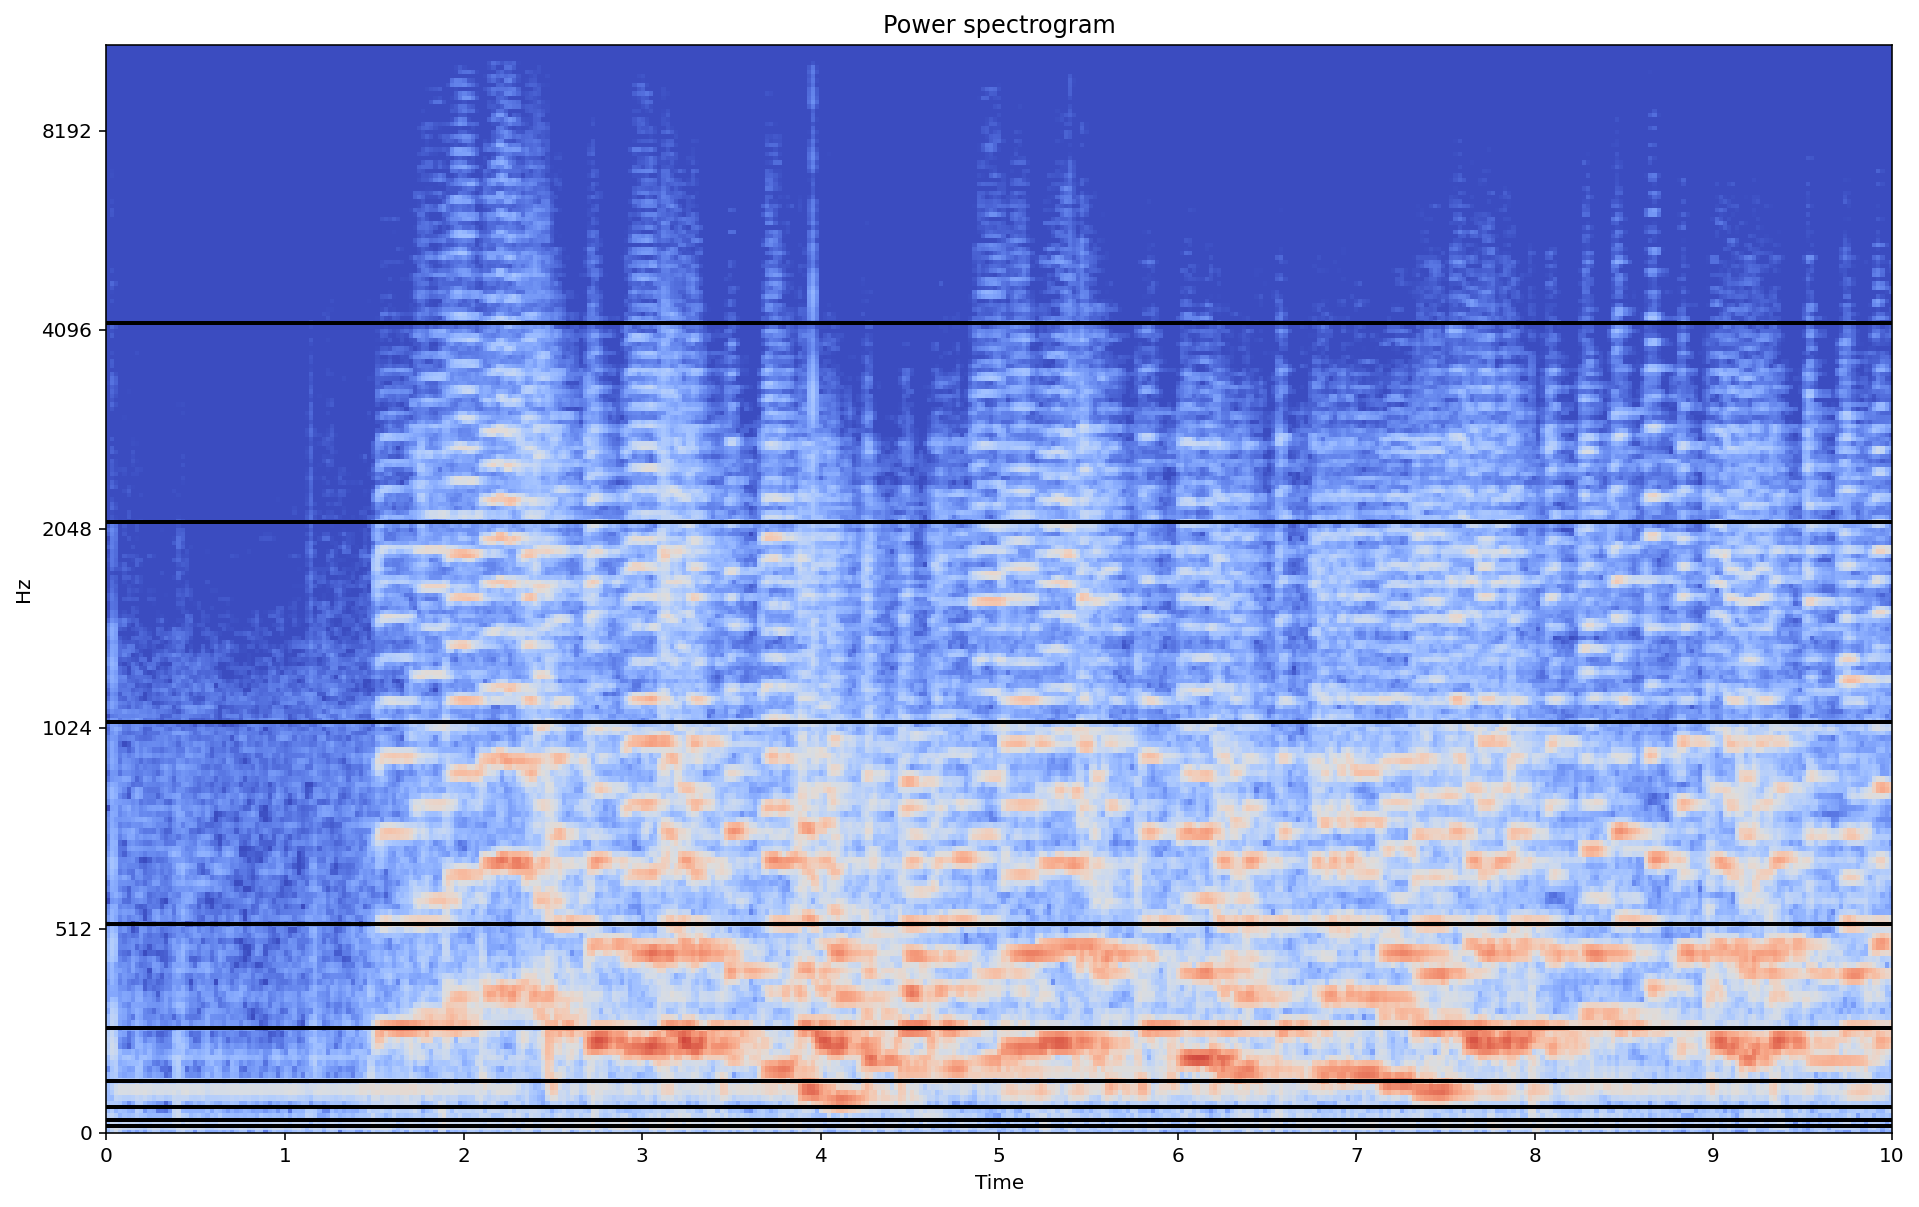

In [ ]:
melsMinMin, melsMinMax, melsMeanMin, melsMeanMax, melsMaxMin, melsMaxMax = -43, -36, -26, -3, 37, 44

mels = lbr.power_to_db(lbr.magphase(lbr.feature.melspectrogram(song, rate, n_mels=229, fmin=30, htk=True))[0])
print('{} frames,\tmels decibels in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(
    mels.shape[1], mels.min(), mels.mean(), mels.max()))

def PlotMelSpectrum(title):
    plt.title(title)
    specshow(mels, x_axis='time', y_axis='mel')
    plt.hlines([lbr.note_to_hz('C0'), lbr.note_to_hz('C1'), lbr.note_to_hz('C2'), lbr.note_to_hz('C3'), lbr.note_to_hz('C4'),
                lbr.note_to_hz('C5'), lbr.note_to_hz('C6'), lbr.note_to_hz('C7'), lbr.note_to_hz('C8')], 0, 10, linewidth=2)
    plt.xlim(0, 10)

plt.figure(figsize=(16, 10))
PlotMelSpectrum('Power spectrogram')

# 3. Load RNN-Models and Predict Probabilities.

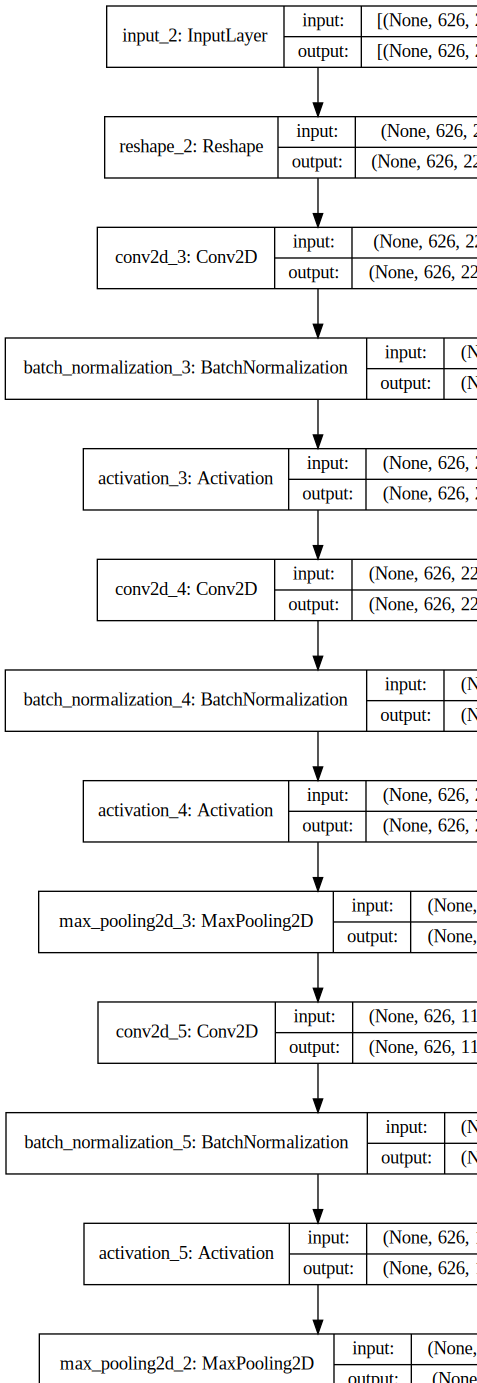

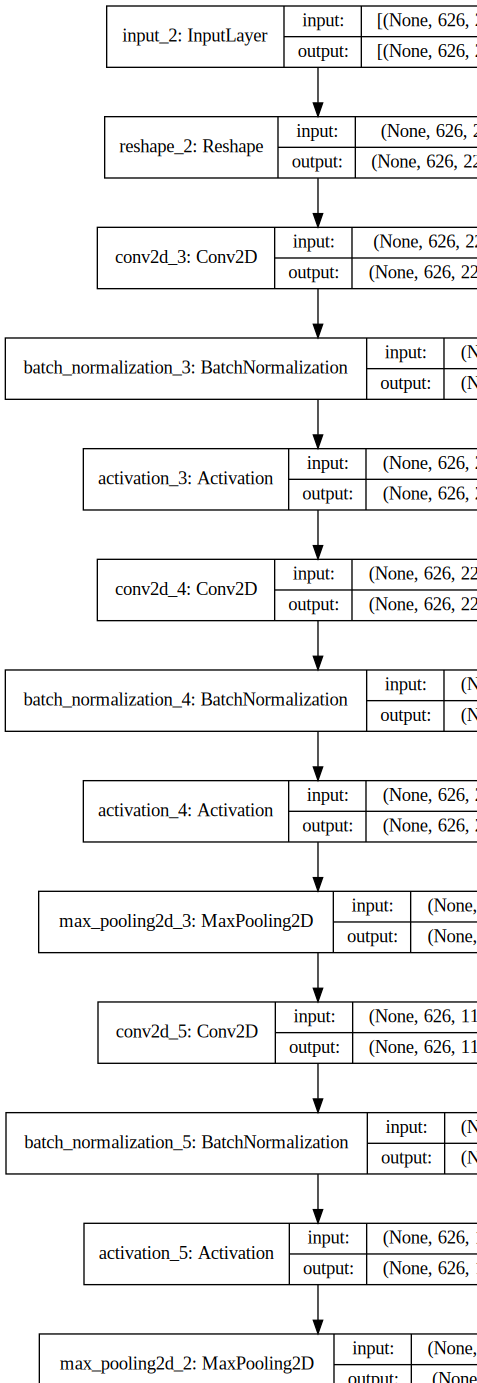

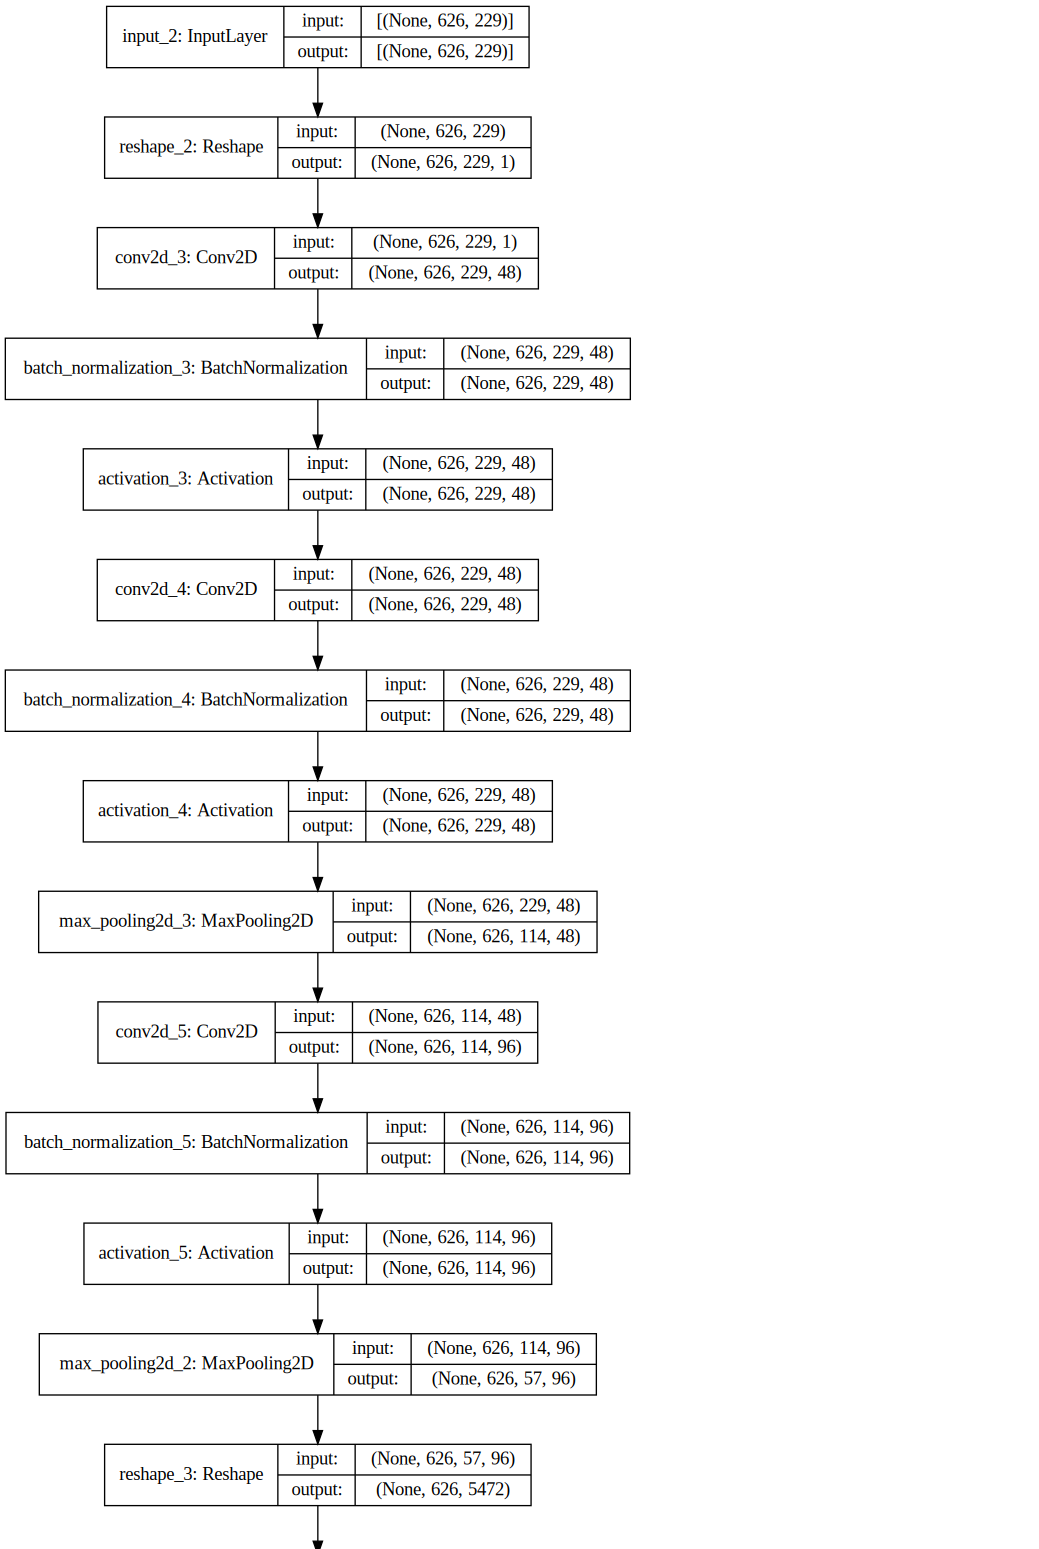

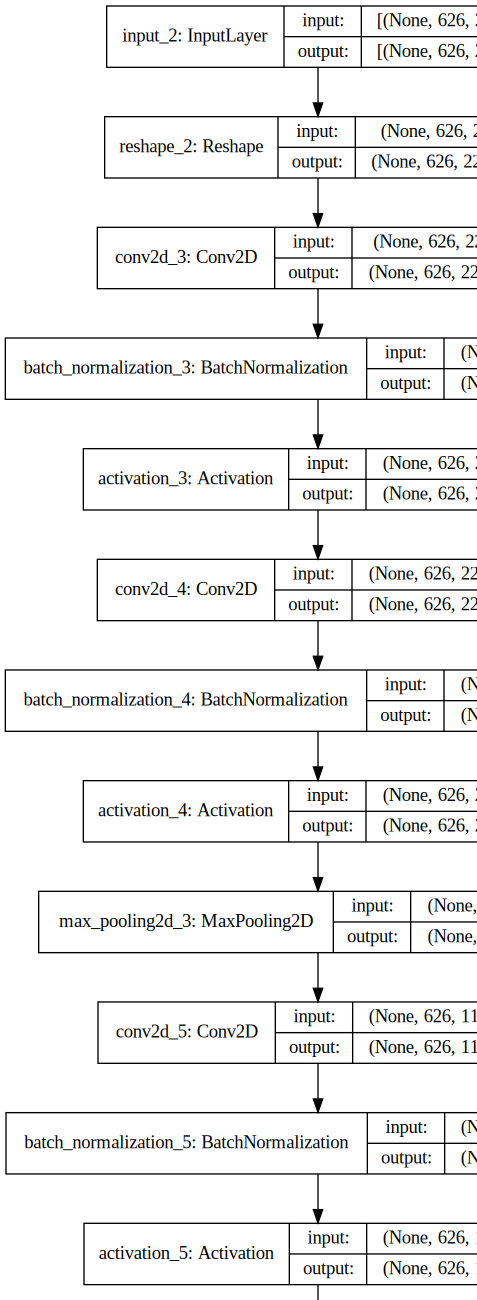

1/1 [==============================] - 160s 160s/step


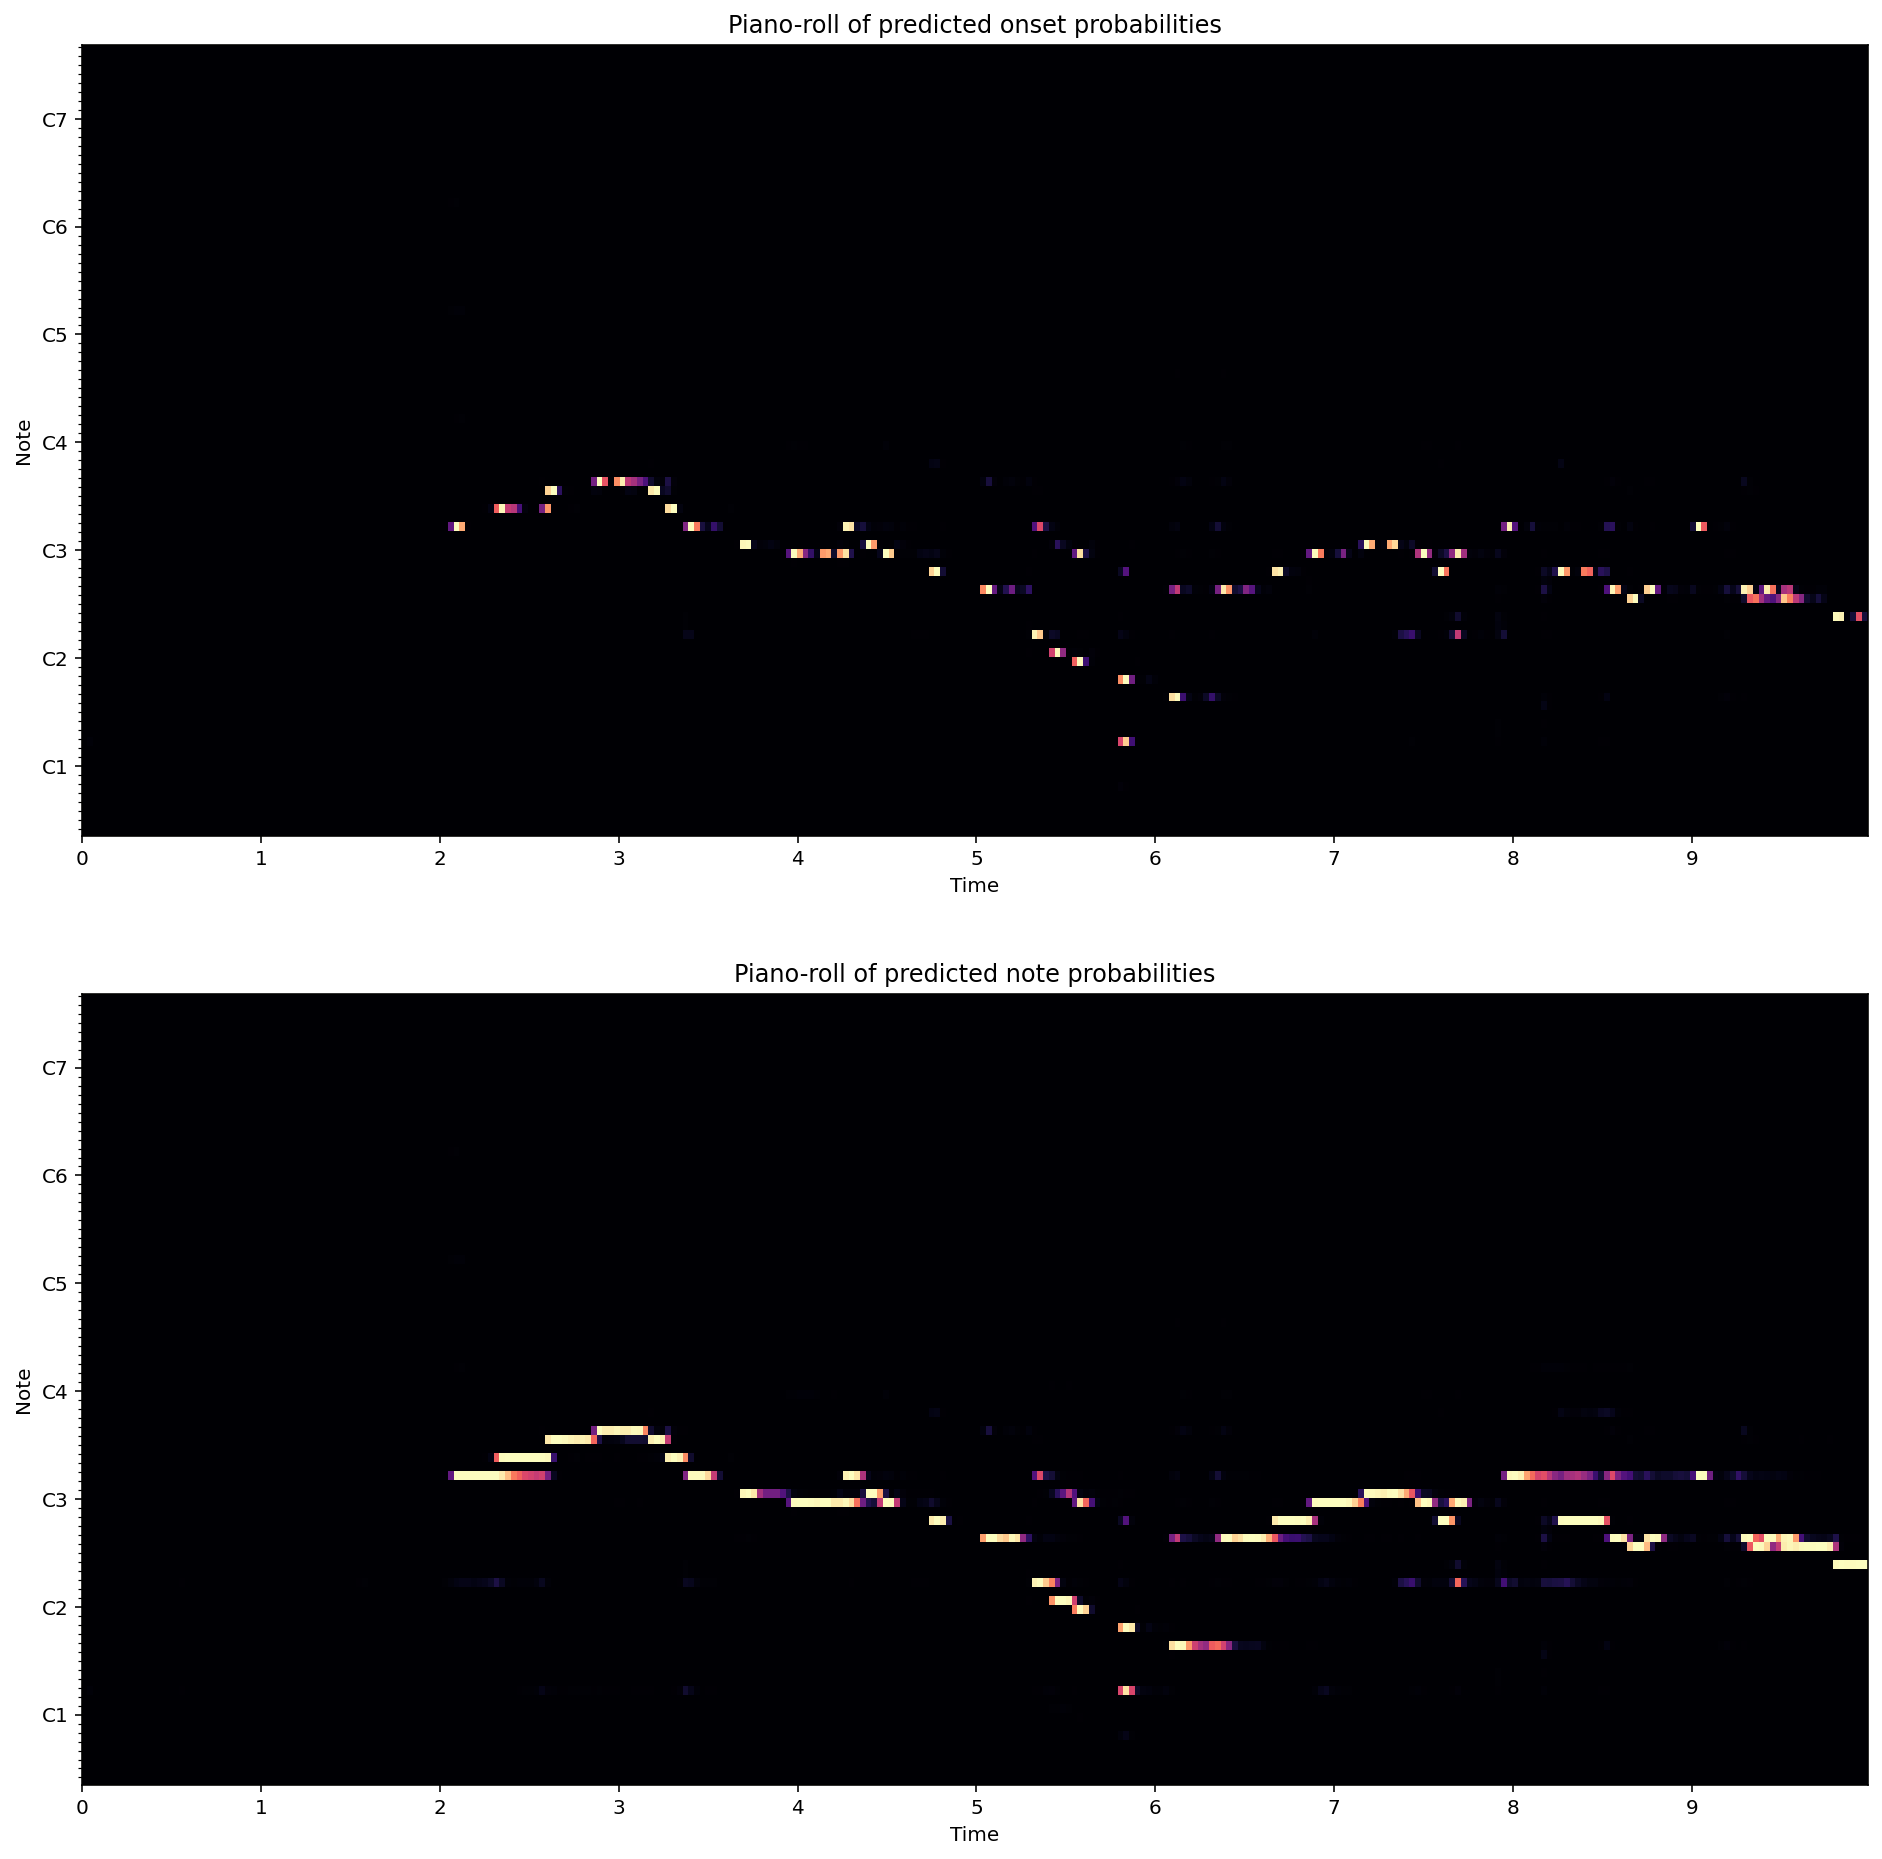

In [ ]:
nFrames = lbr.time_to_frames(20, rate) + 1

melsReshaped = np.pad(mels, [(0, 0), (0, -mels.shape[1] % nFrames)], 'minimum').T.reshape((-1, nFrames, len(mels)))
#onMod, offMod, actMod, volMod = map(lambda name, accTrain, accVal: load_model(
#    'Models/Training {} Model {:.2f} {:.2f}.hdf5'.format(name, accTrain, accVal), compile=False),
#    ['Onsets', 'Offsets', 'Actives', 'Volumes'], [63.98, 43.21, 83.18, 98.72], [64, 39.53, 78.88, 96.95])
onMod, offMod, actMod, volMod = map(lambda name: load_model('/content/drive/My Drive/maestro-v1.0.0/pre_trained/Magenta {}.hdf5'.format(name), compile=False),
                                    ['Onsets 67.90', 'Offsets 46.80', 'Frame 79.16', 'Velocity 94.26'])
for model in [onMod, offMod, actMod, volMod]: display(SVG(model_to_dot(model, True, False, 'LR').create(format='svg')))

onProb, offProb, volProb = map(lambda mod: mod.predict(melsReshaped, 32, 1), [onMod, offMod, volMod])
#actProb = actMod.predict([melsReshaped, onProb, offProb], 32, 1)
actProb = actMod.predict([onProb, melsReshaped, offProb], 32, 1)
onProb, actProb, volProb = map(lambda arr: np.vstack(arr)[:mels.shape[1]], [onProb, actProb, volProb])

plt.figure(figsize=(16, 16))
def PlotRoll(i, yProb, name):
    plt.subplot(2, 1, i)
    specshow(yProb[0:lbr.time_to_frames(10, rate)].T, x_axis='time', y_axis='cqt_note', sr=rate, fmin=lbr.note_to_midi('A0'))
    plt.title('Piano-roll of predicted {} probabilities'.format(name))

PlotRoll(1, onProb, 'onset')
PlotRoll(2, np.maximum(onProb, actProb), 'note')

# 4 Keep Only Notes with Probabilities >= some threshold.
From https://arxiv.org/pdf/1710.11153.pdf:

Page 1 "Abstract":

`During inference, we restrict the predictions from the framewise detector by not allowing a new note to start unless the onset detector also agrees that an onset for that pitch is present in the frame.`

Page 2, Section 3 "Model Configuration":

`An activation from the frame detector is only allowed to start a note if the onset detector agrees that an onset is present in that frame.`

Page 3, Section 3.1 "Velocity Estimation":

`At inference time the output is ... then transformed to a midi velocity by the following mapping:`
$$v_{midi} = 80 * v_{predicted} + 10$$
`The final mapping is arbitrary, but we found this leads to pleasing audio renderings.`

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


([], ['C', 'E', 'G', 'D', 'B', 'A', 'F'])

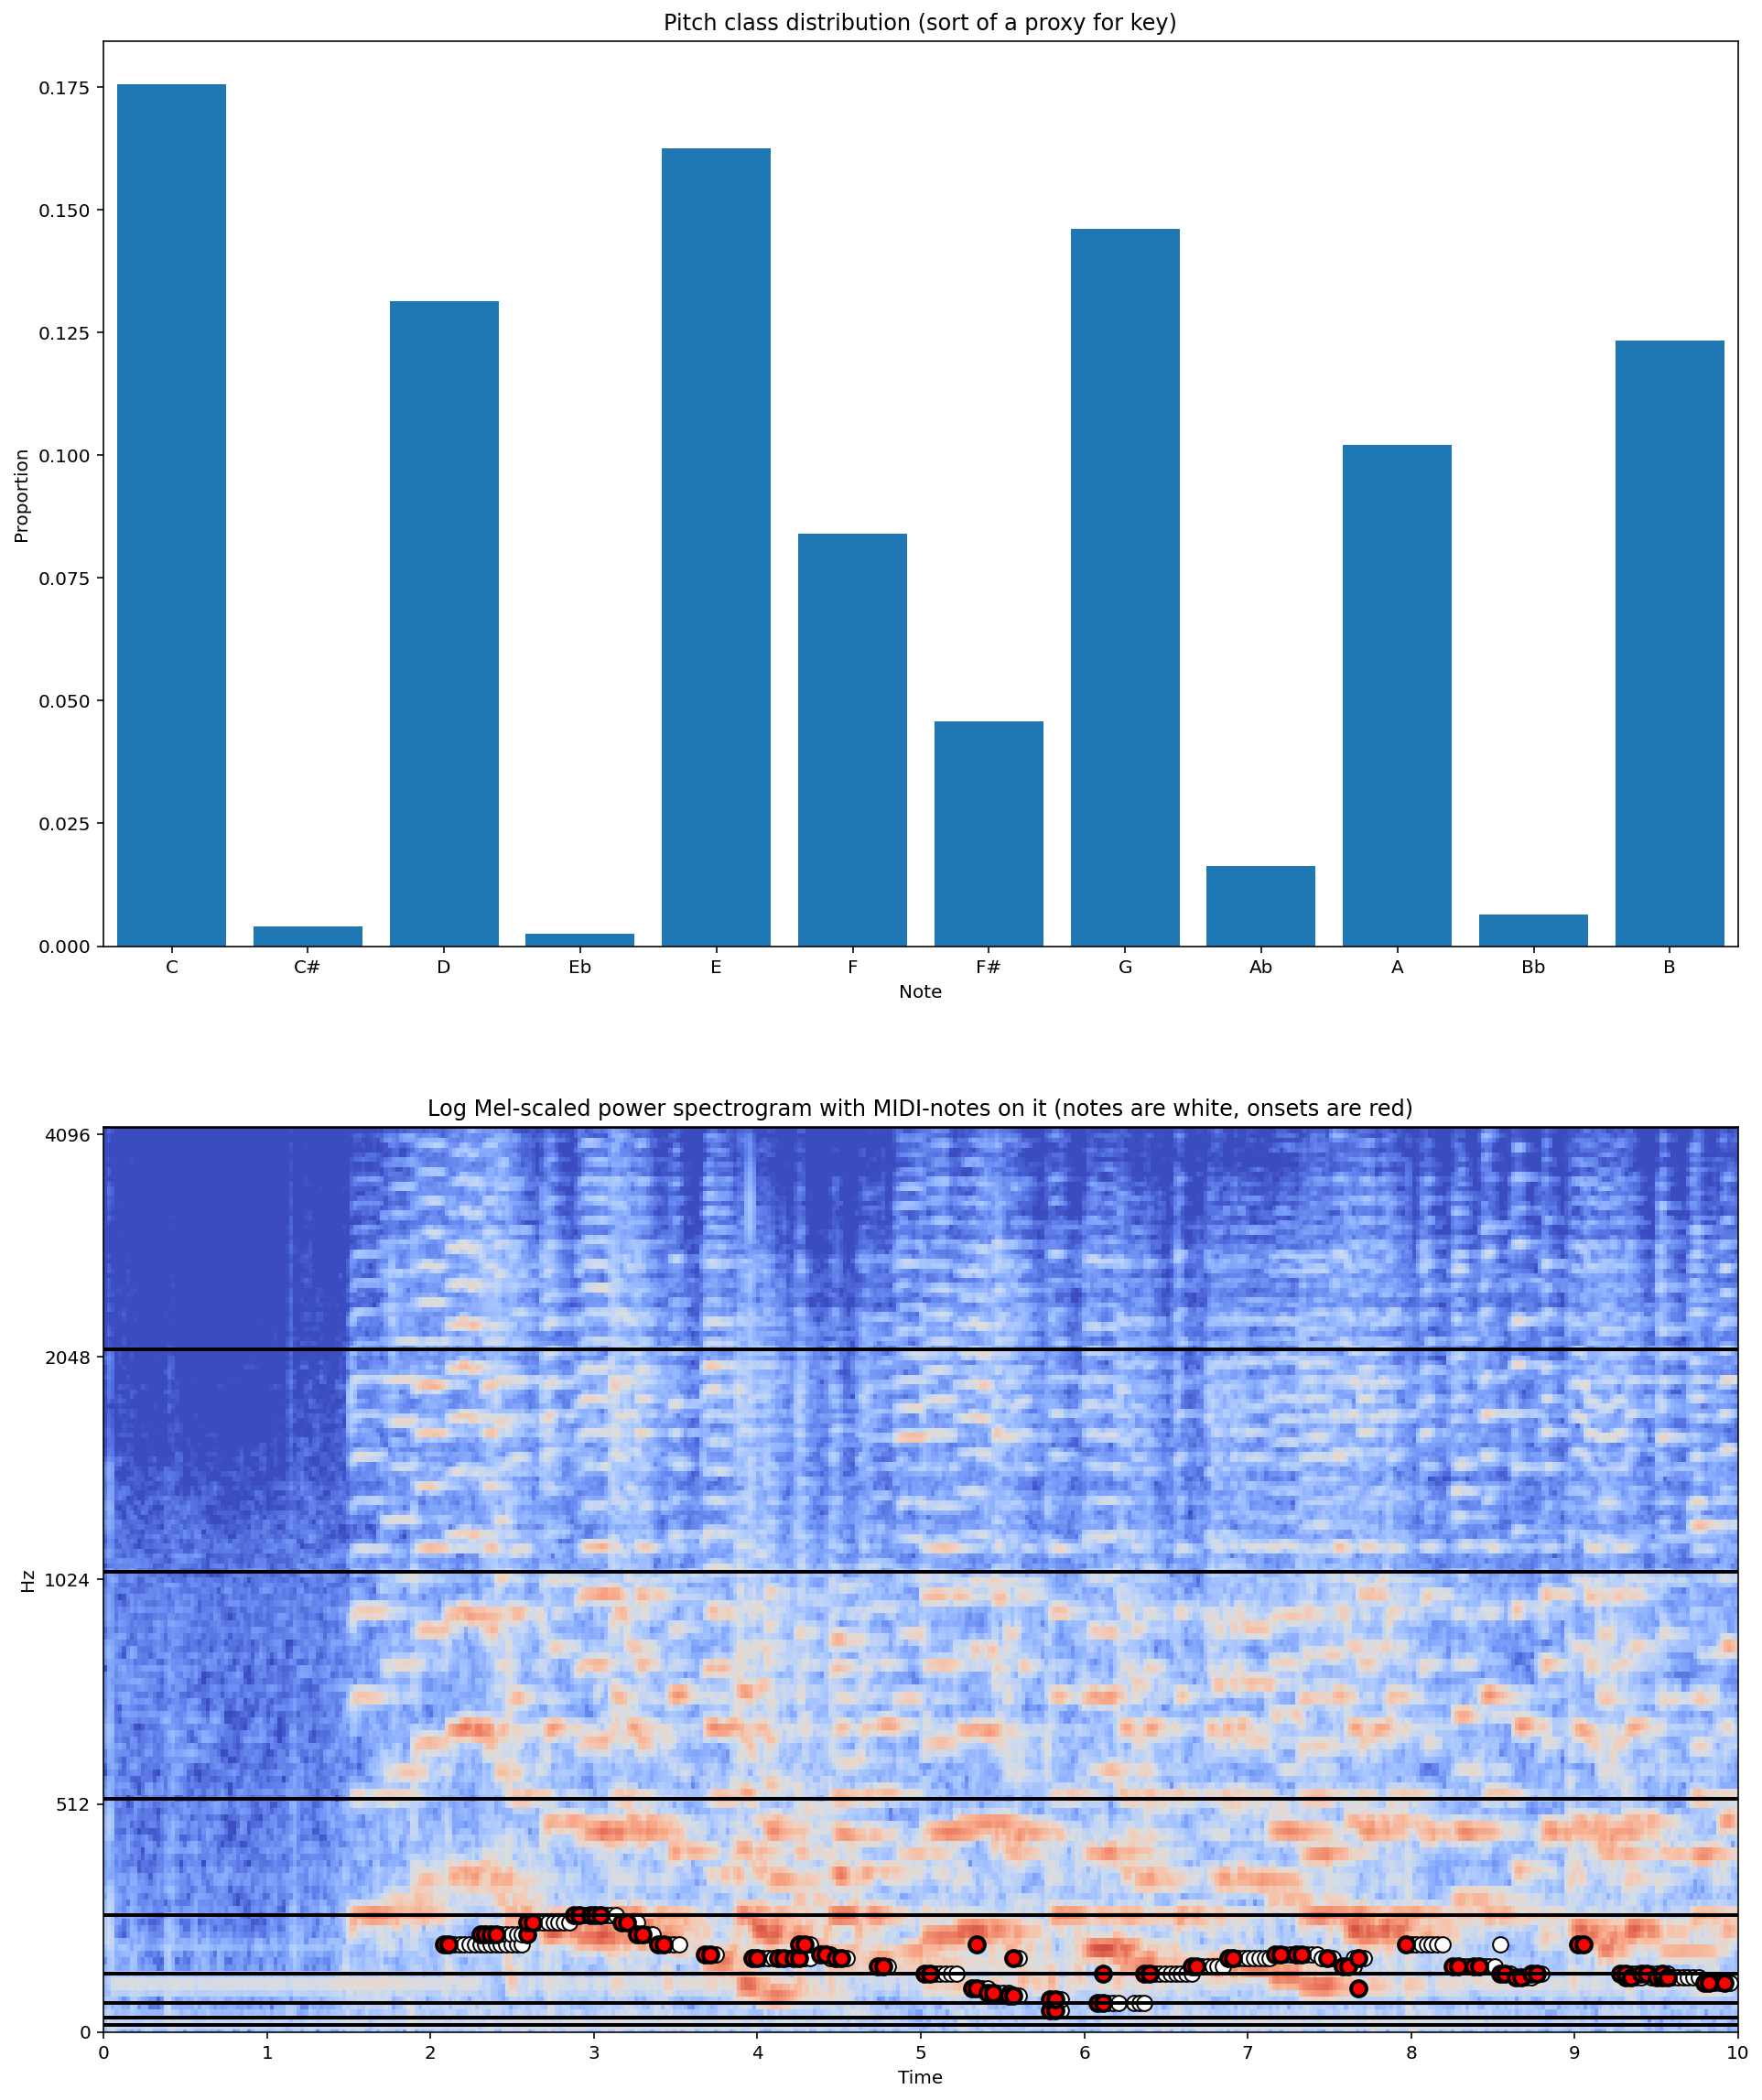

In [ ]:
midi = pm.PrettyMIDI(initial_tempo=lbr.beat.tempo(song, rate).mean())
midi.lyrics += [pm.Lyric('Automatically transcribed from audio:\r\n\t' + songName, 0),
                pm.Lyric('Used software created by Boris Shakhovsky', 0)]
track = pm.Instrument(program=pm.instrument_name_to_program('Cello'), name='Acoustic Grand Piano')
midi.instruments += [track]

''' Based on https://github.com/tensorflow/magenta/blob/master/magenta/music/sequences_lib.py#L1844
    magenta.music.midi_ionote_sequence_to_midi_file(
    magenta.music.sequences_libpianoroll_to_note_sequence(fps=rate/512, min_duration=0, min_midi_pitch=21 ... '''

intervals, frameLenSecs = {}, lbr.frames_to_time(1, rate) # Time is in absolute seconds, not relative MIDI ticks
onsets = (onProb > .5).astype(np.int8)
frames = onsets | (actProb > .5).astype(np.int8) # Ensure that any frame with an onset prediction is considered active.

def EndPitch(pitch, endFrame):
    track.notes += [pm.Note(int(volProb[intervals[pitch], pitch] * 80 + 10), pitch + 21,
                            intervals[pitch] * frameLenSecs, endFrame * frameLenSecs)]
    del intervals[pitch]

# Add silent frame at the end so we can do a final loop and terminate any notes that are still active:
for i, frame in enumerate(np.vstack([frames, np.zeros(frames.shape[1])])):
    for pitch, active in enumerate(frame):
        if active:
            if pitch not in intervals:
                if onsets is None: intervals[pitch] = i
                elif onsets[i, pitch]: intervals[pitch] = i # Start a note only if we have predicted an onset
                #else: Even though the frame is active, there is no onset, so ignore it
            elif onsets is not None:
                if (onsets[i, pitch] and not onsets[i - 1, pitch]):
                    EndPitch(pitch, i)   # Pitch is already active, but because of a new onset, we should end the note
                    intervals[pitch] = i # and start a new one
        elif pitch in intervals: EndPitch(pitch, i)

if track.notes: assert len(frames) * frameLenSecs >= track.notes[-1].end, 'Wrong MIDI sequence duration'


plt.figure(figsize=(16, 20))
plt.subplot(2, 1, 1)

notes = midi.get_pitch_class_histogram()
plt.bar(np.arange(12), notes)
plt.xticks(np.arange(12), ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B'])
plt.title('Pitch class distribution (sort of a proxy for key)')
plt.xlabel('Note')
plt.ylabel('Proportion')
plt.xlim(-.5, 11.5)

plt.subplot(2, 1, 2)
x, y, xOn, yOn = [], [], [], []
for time, frame in enumerate(frames[:lbr.time_to_frames(10, rate)]):
    for n, onOff in enumerate(frame):
        if onOff:
            x += [lbr.frames_to_time(time, rate)]
            y += [lbr.midi_to_hz(n + 21)]
        if onsets[time, n]:
            xOn += [lbr.frames_to_time(time, rate)]
            yOn += [lbr.midi_to_hz(n + 21)]
PlotMelSpectrum('Log Mel-scaled power spectrogram with MIDI-notes on it (notes are white, onsets are red)')
plt.scatter(x,   y,   70, 'w', linewidths=1, edgecolors='black')
plt.scatter(xOn, yOn, 70, 'r', linewidths=2, edgecolors='black')
plt.ylim(0, lbr.note_to_hz('C8'))

gamma = [n for _, n in sorted([(count, ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B'][i])
                               for i, count in enumerate(notes)], reverse=True)[:7]]
blacks = sorted(n for n in gamma if len(n) > 1)
blacks, gamma

# 7.1 Key Signature Estimation, Option 1.
### From Kumhansl and Schmuckler as reported here:
http://rnhart.net/articles/key-finding/

In [ ]:
chroma = lbr.feature.chroma_cqt(song, rate).sum(1)
major = [np.corrcoef(chroma, np.roll([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88], i))[0, 1] for i in range(12)]
minor = [np.corrcoef(chroma, np.roll([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17], i))[0, 1] for i in range(12)]
keySignature = (['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B'][
    major.index(max(major)) if max(major) > max(minor) else minor.index(max(minor)) - 3]
                + ('m' if max(major) < max(minor) else ''))
keySignature

'C#m'

In [ ]:
chroma = lbr.feature.chroma_cqt(C=onsets.T, fmin=lbr.note_to_hz('A0')).sum(1)
major = [np.corrcoef(chroma, np.roll([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88], i))[0, 1] for i in range(12)]
minor = [np.corrcoef(chroma, np.roll([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17], i))[0, 1] for i in range(12)]
keySignature = (['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B'][
    major.index(max(major)) if max(major) > max(minor) else minor.index(max(minor)) - 3]
                + ('m' if max(major) < max(minor) else ''))
keySignature

'E'

# 7.2 Key Signature Estimation, Option 2.

In [ ]:
MajorMinor = lambda mj, mn: mj if gamma.index(mj) < gamma.index(mn) else mn + 'm'

if len(blacks) == 0: keySignature = MajorMinor('C', 'A')

elif len(blacks) == 1:
    if blacks[0] == 'F#':
        assert 'F' not in gamma
        keySignature = MajorMinor('G', 'E')
    elif blacks[0] == 'Bb':
        assert 'B' not in gamma
        keySignature = MajorMinor('F', 'D')
    else: assert False

elif len(blacks) == 2:
    if blacks == ['C#', 'F#']:
        assert 'C' not in gamma and 'F' not in gamma
        keySignature = MajorMinor('D', 'B')
    elif blacks == ['Bb', 'Eb']:
        assert 'B' not in gamma and 'E' not in gamma
        keySignature = MajorMinor('Bb', 'G')
    else: assert False

elif len(blacks) == 3:
    if blacks == ['Ab', 'C#', 'F#']:
        assert 'C' not in gamma and 'F' not in gamma and 'G' not in gamma
        keySignature = MajorMinor('A', 'F#')
    elif blacks == ['Ab', 'Bb', 'Eb']:
        assert 'B' not in gamma and 'E' not in gamma and 'A' not in gamma
        keySignature = MajorMinor('Eb', 'C')
    else: assert False

elif len(blacks) == 4:
    if blacks == ['Ab', 'C#', 'Eb', 'F#']:
        assert 'C' not in gamma and 'D' not in gamma and 'F' not in gamma and 'G' not in gamma
        keySignature = MajorMinor('E', 'C#')
    elif blacks == ['Ab', 'Bb', 'C#', 'Eb']:
        assert 'B' not in gamma and 'E' not in gamma and 'A' not in gamma and 'D' not in gamma
        keySignature = MajorMinor('Ab', 'F')
    else: assert False

elif 'B' in gamma and 'E' in gamma: keySignature = MajorMinor('B', 'Ab')
elif 'C' in gamma and 'F' in gamma: keySignature = MajorMinor('C#', 'Bb')
else: assert False

keySignature

'C'

# 8. Finally, Write MIDI.
No instrument information is extracted, and all transcribed notes get combined into one part.

In [ ]:
midi.key_signature_changes += [pm.KeySignature(pm.key_name_to_key_number(keySignature), 0)]
songName = '.'.join(songName.split('.')[:-1]) + '_magenta.mid'
midi.write(songName)
'{} saved'.format(songName)

'/content/drive/My Drive/maestro-v1.0.0/2021/2218_magenta.mid saved'